## Intro

In [2]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from config import BASE_DIR
RERUN = False

The main purpose of this doc, is trying to determine the right number of topics for our corpus (currently handling only nonbib, hebrew texts).
Ive sucseeded to lemmatize the text with the [dictabert-lex](https://huggingface.co/dicta-il/dictabert-lex) model which attempts to match up each word with the correct lexeme from within the BERT vocabulary.
This doc structure is as follows:
1. What are the problems in the current research for dealing with the problem of choosing the right number of topics.
2. Some additional pre-processing to the corpus.
3. Choosing number of topics:
    1. Running multiple LDA models with a different number of optional topics and plot varoius metrics.
    2. Running hierarchical dirichlet process for inferring number of topics.
    3. Hyper parameter tuning for best number of topics.
4. Short analysis of the topics after selecting (probably) the right number of topics. Chosen number of topics = 18-19 (regular text 18, lemmatized 19)



TODO: 
1. Implement more models (BertTopic, LSA, etc).

## Data

In [5]:


DATA_PATH = f"{BASE_DIR}/notebooks/data/filtered_text_and_starr_features_100_words_22_05_2024.csv"
df = pd.read_csv(DATA_PATH)
df_grouped = df.groupby("book")["text"].apply(' '.join).reset_index()
book_info = df[["book", "composition", "section", "text_lex"]].drop_duplicates()
df_by_book = pd.merge(df_grouped, book_info, on="book", how="inner").drop_duplicates(["book"])


df_by_book


,book,text,composition,section,text_lex
0,11Q1,וסמכ ידו על ראש השעיר ושחט אתו במקומ אשר ישחט...,Lev,NaN,סמך יד ראש עיר שחט את מקום שחט עלה פנה יהוה חט...
20,11Q11,וה כב הא ם ע דם סוכות לם ו ה ת יך ב את שבעים ...,NaN,NaN,וה כב א ם ע דם סוכ לם ה יך ב שבעים ל מים אחד ת...
27,11Q12,הודענו בצאתנו לפני יהוה אלוהינו את כול החטאות...,Book_of_Jubilees,non_sectarian_texts,ידע יצא פנה יהוה אלהים כל חטאת עה שמים ארץ אור...
32,11Q13,שון מושה כיא ש מ על ל ואשר אמר בשנת היובל הזו...,NaN,NaN,שון משה ש מ על ל אמר שנה יובל זה שוב איש אחזה ...
38,11Q17,ים מ האור מ סדרותיו סדרותיו מבנית שי קודש ישמ...,NaN,NaN,מ אור מ דרה דרה מבנית ש קדש שמע תהלה אלהים מ א...
...,...,...,...,...,...
2970,Sdeir1,אשר סביבתיהם ולא רדפו אחרי בני יעקב ויבא יעקב ...,NaN,NaN,סביב רדף בן יעקב בוא יעקב לוז ארץ כנען היא בית...
2974,Xhev/se5,וידבר יהוה אל משה לאמר קדש לי כל בכור בבני ישר...,NaN,NaN,דבר יהוה משה אמר קדש ל כל בכר בן יראל אדם ב ב ...
2979,Xq1,ויאמר יהוה אל משה ואהרן זאת חקת הפסח כל בן נכר...,NaN,NaN,אמר יהוה משה אהרן זה חקה פסח כל בן נכר אכל ב כ...
2983,Xq2,את הדברים האלה דבר יהוה עם כל קהלכם בהר מתוך ה...,NaN,NaN,דבר אלה דבר יהוה כל קהל הר תוך אש חשך ענן ערפל...


## Topic modeling

### Choosing the right number of topics

In [6]:
import gensim
from gensim import corpora
import tomotopy as tp
import pandas as pd
from scipy.spatial import distance
from datetime import datetime
from collections import Counter

# Functions related to word frequency analysis
def get_top_n_words(texts, n):
    word_counts = Counter([word for text in texts for word in text])
    return [word[0] for word in word_counts.most_common(n)]


def get_bottom_n_words(texts, n):
    word_counts = Counter([word for text in texts for word in text])
    return [word[0] for word in word_counts.most_common()[:-n - 1:-1]]


def remove_words_from_text(texts, words_to_remove):
    new_texts = []
    for text in texts:
        new_texts.append([word for word in text if word not in words_to_remove])
    return new_texts


def bigram_per_prcosessing(texts, min_count_bigram, threshold_bigram):
    bigram = gensim.models.Phrases(texts, min_count=min_count_bigram, threshold=threshold_bigram)
    texts = [bigram[text] for text in texts]
    return texts


def common_non_common_words_removal(texts, top_words_removal, bottom_words_removal):
    most_common_words = get_top_n_words(texts, top_words_removal)
    texts = remove_words_from_text(texts, most_common_words)
    least_common_words = get_bottom_n_words(texts, bottom_words_removal)
    texts = remove_words_from_text(texts, least_common_words)

    print(f"Removed {most_common_words=}, {least_common_words=} from text")
    return texts


def generate_components(df, column, min_count_bigram, threshold_bigram, top_words_removal,
                        bottom_words_removal, words_removal=True, bigram_process=True):
    texts = [[word for word in str(doc).split(" ")] for doc in df[column]]
    if bigram_process:
        texts = bigram_per_prcosessing(texts, min_count_bigram, threshold_bigram)
    if words_removal:
        texts = common_non_common_words_removal(texts, top_words_removal, bottom_words_removal)
    return texts


In [7]:
texts = generate_components(df_by_book,"text_lex",min_count_bigram=1, threshold_bigram=4, top_words_removal=8, bottom_words_removal=10, words_removal=True,
                                                         bigram_process=False)

texts = [" ".join(doc) for doc in texts]


Removed most_common_words=['כל', 'ל', 'יהוה', 'יום', 'אמר', '', 'ב', 'אלהים'], least_common_words=['כיר', 'תושב', 'רחל', 'בכות', 'ינק', 'לוז', 'חזיון', 'צחנה', 'באש', 'קדמני'] from text


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(texts).toarray()
with open('data/data_all_scrolls_lex.npy', 'wb') as f:
    np.save(f, X)
X.shape



(202, 1868)

10
4


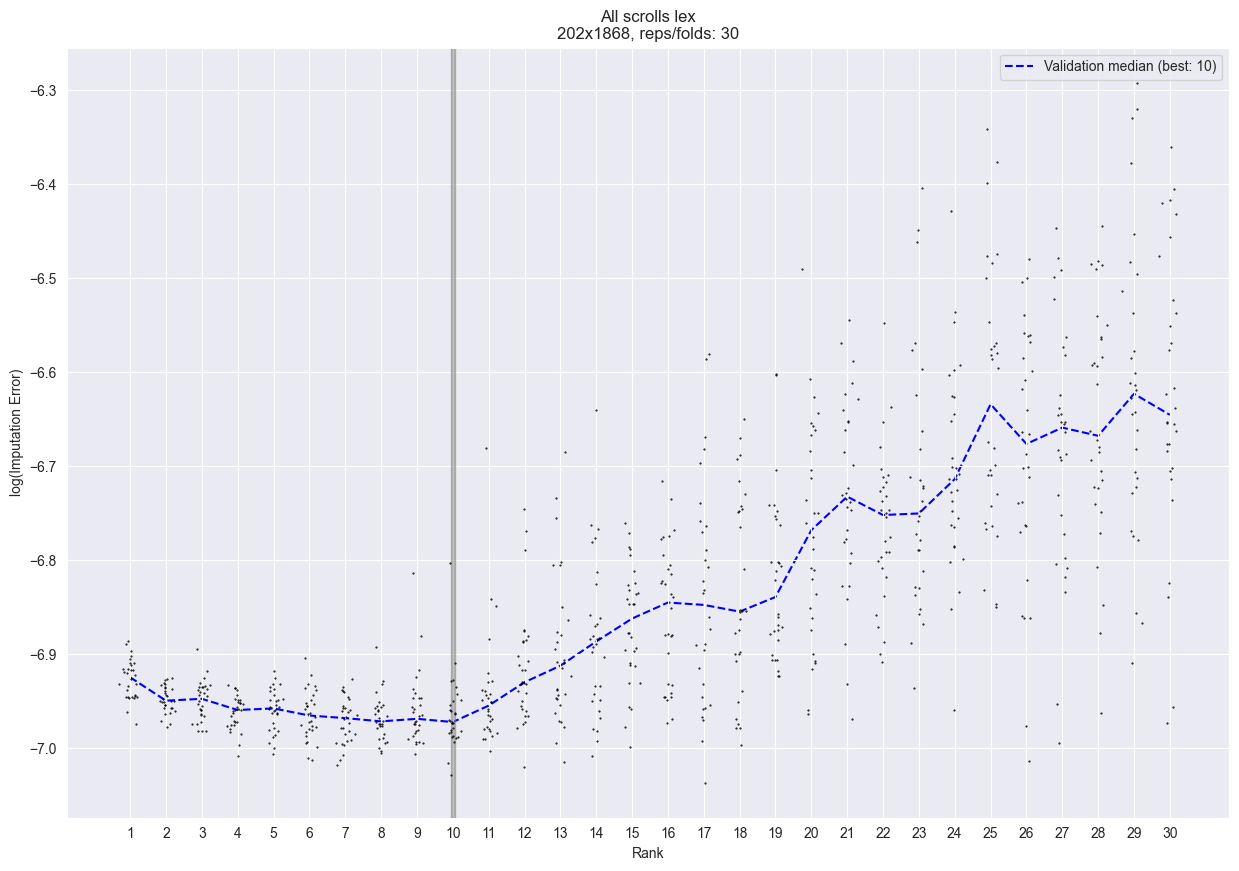

In [10]:
from config import BASE_DIR

errors = np.load(f"{BASE_DIR}/notebooks/data/errors_all_lex_reps-30_obj-jk_frac-0.1_k-1_30_max_iter-2000.npy")
Ks = list(range(1,30+1))

def produce_figure(errors, rollback=False):
    """
    produces a figure that shows the results
    :param rollback: int - chosen k, after rolling backwards from the k with minimum median error
    """
    
    medians = np.nanmedian(errors, axis=1)
    fig, ax = plt.subplots(figsize=(15,10))
    title_str = "All scrolls lex" + "\n%dx%d, reps/folds: %d" % (202, 1868, 30)
    plt.title(title_str)
    plt.xlabel('Rank')
    plt.ylabel('log(Imputation Error)')
    rank_cycle = np.array([[i] * 30 for i in Ks]).flatten()
    plt.plot(rank_cycle + np.random.randn(rank_cycle.size) * .1, np.log(errors.flatten()), '.k', markersize=1)  # scatter
    plt.plot(Ks, np.log(medians), 'b--', zorder=-1, label='Validation median (best: %d)' % best_k)
    plt.legend(loc='best')
    plt.xticks(Ks)
    
    if rollback:
        plt.axvspan(best_k_after_rollback - 0.05, best_k_after_rollback + 0.05, color='gray', alpha=0.5)
    else:
        plt.axvspan(best_k - 0.05, best_k + 0.05, color='gray', alpha=0.5)

    plt.show()
import scipy
def rollback(errors):
    """
    Finds K after rolling backwards from the k with minimum median value, using Wilcoxon rank-sum test
    :param errors: numpy array of errors (Ks x repetitions)
    :return: index of K after rollback
    """
    best_k_arg = np.argmin(np.nanmedian(errors, axis=1))
    # rollback
    for k in range(best_k_arg):
        best_k_runs = errors[best_k_arg]
        next_k_runs = errors[k]
        u, p = scipy.stats.ranksums(next_k_runs, best_k_runs)
        if p > 0.05:
            best_k_arg = k
            break
    return best_k_arg
best_k_arg = np.argmin(np.nanmedian(errors, axis=1))
best_k = Ks[best_k_arg]
# rollback
best_k_after_rollback_idx = rollback(errors)
best_k_after_rollback = Ks[best_k_after_rollback_idx]
print(best_k)
print(best_k_after_rollback)
produce_figure(errors)

### Selected topic model analysis

In [11]:
import pandas as pd
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import corpora, models
import re

def generate_dominant_topic_df(model, corpus, original_texts=None, feature_names=None, model_type='nmf'):
    df_topic_sents_keywords = pd.DataFrame()

    if model_type == 'nmf':
        W = model.transform(corpus)
        for i, row in enumerate(W):
            sorted_row = sorted(enumerate(row), key=lambda x: x[1], reverse=True)
            for j, (topic_num, prop_topic) in enumerate(sorted_row):
                if j == 0:
                    topic_keywords = ", ".join([feature_names[word] for word in model.components_[topic_num].argsort()[:-11:-1]])
                    df_topic_sents_keywords = pd.concat(
                        [df_topic_sents_keywords,
                         pd.DataFrame([[int(topic_num), round(prop_topic, 4), topic_keywords]],
                                      columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])],
                        ignore_index=True)
                else:
                    break
    elif model_type == 'lda':
        for i, row_list in enumerate(model[corpus]):
            row = row_list[0] if model.per_word_topics else row_list
            row = sorted(row, key=lambda x: (x[1]), reverse=True)
            for j, (topic_num, prop_topic) in enumerate(row):
                if j == 0:
                    wp = model.show_topic(topic_num)
                    topic_keywords = ", ".join([word for word, prop in wp])
                    df_topic_sents_keywords = pd.concat(
                        [df_topic_sents_keywords,
                         pd.DataFrame([[int(topic_num), round(prop_topic, 4), topic_keywords]],
                                      columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])],
                        ignore_index=True)
                else:
                    break

    contents = pd.Series(original_texts)
    df_topic_sents_keywords = pd.concat([df_topic_sents_keywords, contents], axis=1)
    df_topic_sents_keywords.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Text']
    df_topic_sents_keywords["book"] = df_by_book.reset_index()["book"]

    # Format
    df_dominant_topic = df_topic_sents_keywords.reset_index()
    df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'book']
    return df_dominant_topic

def print_top_topics_by_percentage(model, df_dominant_topic, model_type, feature_names=None, num_words=15):
    topics_by_freq = df_dominant_topic.groupby("Dominant_Topic")["Document_No"].count().sort_values(
        ascending=False).to_frame()
    topics_by_freq["freq"] = topics_by_freq["Document_No"] / topics_by_freq["Document_No"].sum()
    topics_by_freq.reset_index(inplace=True)
    sorted_topics = topics_by_freq.sort_values(by="freq", ascending=False)["Dominant_Topic"].to_list()

    if model_type == 'nmf':
        topics = []
        for topic_idx, topic in enumerate(model.components_):
            words = [feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]]
            topics.append((topic_idx, ", ".join(words)))
        
        topics = [topics[int(i)] for i in sorted_topics]
        cleaned_topics = [topic[1] for topic in topics]
    elif model_type == 'lda':
        topics = model.print_topics(num_topics=-1, num_words=num_words)
        topics = [topics[int(i)] for i in sorted_topics]
        cleaned_topics = []
        for topic_no, topic in topics:
            words = re.findall(r'"([^"]*)"', topic)
            cleaned_topics.append(', '.join(sorted(words)))

    print(f"{model_type.upper()} num_topics={len(sorted_topics)}, sorted by % from all docs")
    for i, topic in zip(sorted_topics, cleaned_topics):
        doc_n = topics_by_freq[(topics_by_freq["Dominant_Topic"] == i)]["Document_No"].values[0]
        doc_ratio = topics_by_freq[(topics_by_freq["Dominant_Topic"] == i)]["freq"].values[0]
        print(f"Topic {i} ({doc_n} docs, {doc_ratio:.2%} from all docs): {topic}")

# Assuming `texts` is your preprocessed text data and `df_by_book` is your original dataframe
texts = generate_components(df_by_book, "text", min_count_bigram=1, threshold_bigram=4, top_words_removal=8, bottom_words_removal=10, words_removal=True, bigram_process=False)

# NMF model
original_texts = [' '.join(text) for text in texts]
tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(original_texts)
feature_names = tfidf_vectorizer.get_feature_names_out()
nmf_model = NMF(n_components=10, init='random', random_state=0, max_iter=4500)
nmf_model.fit(tfidf)
df_dominant_topic_nmf = generate_dominant_topic_df(nmf_model, tfidf, original_texts, feature_names, model_type='nmf')
print("NMF results")
print_top_topics_by_percentage(nmf_model, df_dominant_topic_nmf, 'nmf', feature_names, num_words=15)

# LDA model
id2word = corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]
lda_model = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=10, random_state=0, update_every=1, passes=10, alpha='auto', per_word_topics=True)
df_dominant_topic_lda = generate_dominant_topic_df(lda_model, corpus, original_texts, model_type='lda')
print("LDA results")
print_top_topics_by_percentage(lda_model, df_dominant_topic_lda, 'lda', num_words=15)


texts = generate_components(df_by_book, "text_lex", min_count_bigram=1, threshold_bigram=4, top_words_removal=8, bottom_words_removal=10, words_removal=True, bigram_process=False)
# NMF model
original_texts = [' '.join(text) for text in texts]
tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(original_texts)
feature_names = tfidf_vectorizer.get_feature_names_out()
nmf_model = NMF(n_components=10, init='random', random_state=0, max_iter=4500)
nmf_model.fit(tfidf)
df_dominant_topic_nmf = generate_dominant_topic_df(nmf_model, tfidf, original_texts, feature_names, model_type='nmf')
print("NMF results")
print_top_topics_by_percentage(nmf_model, df_dominant_topic_nmf, 'nmf', feature_names, num_words=15)

# LDA model
id2word = corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]
lda_model = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=10, random_state=0, update_every=1, passes=10, alpha='auto', per_word_topics=True)
df_dominant_topic_lda = generate_dominant_topic_df(lda_model, corpus, original_texts, model_type='lda')
print("LDA results")
print_top_topics_by_percentage(lda_model, df_dominant_topic_lda, 'lda', num_words=15)


Removed most_common_words=['את', 'יהוה', '', 'אשר', 'אל', 'על', 'כי', 'כול'], least_common_words=['ויוצאך', 'הוציאתך', 'היטבו', 'ומתתנו', 'חמצ', 'ומקנת', 'יבלה', 'ושרתם', 'ויורה', 'ובשערך'] from text
NMF results
NMF num_topics=10, sorted by % from all docs
Topic 8 (39 docs, 19.31% from all docs): לא, כל, צבאות, ולא, אמר, נאם, ישראל, אדני, כה, אני, ביום, בית, ויאמר, יהודה, הארץ
Topic 9 (32 docs, 15.84% from all docs): כיא, לוא, עולם, בכול, לאין, עם, נהיה, לכול, אתה, לכה, אמן, וכול, ברוך, ואתה, ואין
Topic 0 (27 docs, 13.37% from all docs): משה, פרעה, ואת, ישראל, בני, ויאמר, כל, מצרים, אהרן, לא, העם, לכם, לאמר, ליהוה, יוסף
Topic 6 (26 docs, 12.87% from all docs): כיא, לוא, פשרו, ולוא, הואה, ישראל, אמר, ויואמר, המה, פשר, מושה, יעקוב, כתוב, ואת, היאה
Topic 1 (23 docs, 11.39% from all docs): אלהיך, לא, לך, כל, ולא, אנכי, היום, נתן, והיה, הארץ, אלהיכם, פן, מצוך, יהיה, בך
Topic 3 (20 docs, 9.90% from all docs): די, מלכא, מן, ארעא, לה, אנה, שמיא, דן, להון, באדין, לא, אנון, ואמר, חד, רבא
Topic 2

In [15]:
df = pd.read_csv(DATA_PATH)
df = pd.merge(df_dominant_topic_lda[["Dominant_Topic", "book"]], df, on="book")
df = pd.merge(
    df_dominant_topic_lda[["Dominant_Topic", "book"]].rename(columns={"Dominant_Topic": "Dominant_Topic_lem"}),
    df, on="book")
df

,Dominant_Topic_lem,book,Dominant_Topic,sentence_path,text_lex,text,n_words_lex,n_words,construct to absolute nouns ratio,construct nouns and adjectives percentage,...,aCr percentage,oM percentage,kya percentage,all conjunctions percentage,non-finite to finite verbs ratio,passive verb forms percentage,total word count,section,scroll,composition
0,6,11Q1,6,11Q1:fA:1-fB:5,סמך יד ראש עיר שחט את מקום שחט עלה פנה יהוה חט...,וסמכ ידו על ראש השעיר ושחט אתו במקומ אשר ישחט...,75,94,7.500000,0.142857,...,0.0,0.0,0.0,18.095238,0.000000,0.000000,105.0,NaN,NaN,Lev
1,6,11Q1,6,11Q1:fB:5-fC:8,בכה רפה רף יהוה פתח אהל מועד כל הלך גחון כל חי...,יבכו את השרפה אשר שרפ יהוה ופתח אהל מועד לא וכ...,78,93,-1.000000,0.084112,...,0.0,0.0,0.0,15.887850,0.545455,1.869159,107.0,NaN,NaN,Lev
2,6,11Q1,6,11Q1:fC:8-fD:7,ערב טהר צרעת הוא ראה כהן טמא את בהרת לבן היא ע...,עד הערב וטהר צרעת הוא וראהו הכהנ וטמא אתו ואמ ...,76,95,-1.000000,0.009434,...,0.0,0.0,0.0,21.698113,0.066667,0.943396,106.0,NaN,NaN,Lev
3,6,11Q1,6,11Q1:fD:7-fF:3,היא נגע צרעת היה אדם בוא כהן עור בר בהרת כהה ל...,הוא נגע צרעת כי תהיה באדמ והובא אל הכהנ בעור ב...,76,92,-1.000000,0.083333,...,0.0,0.0,0.0,14.814815,0.200000,2.777778,108.0,NaN,NaN,Lev
4,6,11Q1,6,11Q1:fF:4-fGi:3,ימני בהן רגל ימני דם אשם יתר שמן כף כהן נתן רא...,הימנית ועל בהנ רגלו הימנית על דמ האשמ והנותר ב...,75,94,3.333333,0.102804,...,0.0,0.0,0.0,22.429907,0.461538,0.934579,107.0,NaN,NaN,Lev
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2986,3,Xq2,3,Xq2:1:24-1:26,כל נפש כל מאד היה דבר אלה אנכי צוה יום לבב שנן...,ובכל נפשך ובכל מאדך והיו הדברים האלה אשר אנכי ...,32,37,1.500000,0.065217,...,0.0,0.0,0.0,26.086957,0.000000,0.000000,46.0,NaN,NaN,NaN
2987,9,Xq3,9,Xq3:1:1-1:15,קרא משה כל יראל אמר אל שמע יראל חק משפט אנכי ד...,ויקרא משה אל כל יש ראל ויאמר אלהם שמעה ישראל א...,75,94,2.000000,0.056075,...,0.0,0.0,0.0,8.411215,0.363636,0.000000,107.0,NaN,NaN,NaN
2988,9,Xq3,9,Xq3:1:15-1:23,ל פסל כל תמונה שמים ארץ תחת מים תחת ארץ חוה ל ...,לך פסל וכל תמונה אשר בשמים ממעל אשר בארץ מתחת ...,73,95,3.500000,0.066038,...,0.0,0.0,0.0,15.094340,0.571429,0.000000,106.0,NaN,NaN,NaN
2989,9,Xq3,9,Xq3:1:23-1:30,שער נוח עבד אמה כמו זכר עבד היה ארץ מצרים יצא ...,בשעריך למען ינוח עבדך ואמתך כמוך וזכרת כי עבד ...,69,93,6.000000,0.055046,...,0.0,0.0,0.0,15.596330,0.230769,0.917431,109.0,NaN,NaN,NaN


In [13]:
df

,book,sentence_path,text_lex,text,n_words_lex,n_words,construct to absolute nouns ratio,construct nouns and adjectives percentage,noun to verb ratio,definite_article_percentage,...,aCr percentage,oM percentage,kya percentage,all conjunctions percentage,non-finite to finite verbs ratio,passive verb forms percentage,total word count,section,scroll,composition
0,CD,CD:1:1-1:12,שמע כל ידע צדק בין מעה אל ריב ל כל בר משפט עה ...,ועתה שמעו כל יודעי צדק ובינו במעשי אל כי ריב ל...,82,92,0.666667,0.110092,2.250000,0.917431,...,0.0,0.0,0.0,21.100917,0.333333,0.000000,109.0,sectarian_texts,CD,CD
1,CD,CD:1:12-2:1,אחרון עה דור אחרון עדה בגד הם סור דרך היא עת ה...,אחרונים את אשר עשה בדור אחרון בעדת בוגדים הם ס...,85,96,0.545455,0.114286,1.241379,4.761905,...,0.0,0.0,0.0,14.285714,0.705882,0.000000,105.0,sectarian_texts,CD,CD
2,CD,CD:2:1-2:10,כל המון מעה נדה פנה שמע אל כל בוא ברית גלה אזן...,את כל המונם ומעשיהם לנדה לפניו ועתה שמעו אלי כ...,79,94,0.481481,0.130841,2.222222,0.934579,...,0.0,0.0,0.0,17.757009,0.800000,1.869159,107.0,sectarian_texts,CD,CD
3,CD,CD:2:10-2:20,כל שנה עולם כל קום ל קריא שם יתר פליטה ארץ מלא...,לכל שני עולם ובכולם הקים לו קריאי שם למען התיר...,79,94,1.250000,0.205607,1.714286,0.934579,...,0.0,0.0,0.0,17.757009,0.615385,1.869159,107.0,sectarian_texts,CD,CD
4,CD,CD:2:20-3:8,בר היה חרבה גוע היה היה עה רצון שמר מצוה עה חר...,בשר אשר היה בחרבה כי גוע ויהיו כלא היו בעשותם ...,81,95,1.100000,0.103774,1.000000,1.886792,...,0.0,0.0,0.0,18.867925,0.217391,6.603774,106.0,sectarian_texts,CD,CD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2986,Mas1e,Mas1e:1:26-2:11,שלח שררות לב הלך מועצה עם שמע ל יראל דרך הלך מ...,ואשלחהו בשררות לבם ילכו במועצותיהם לו עמי שמע ...,81,89,-1.000000,0.089286,1.260870,2.678571,...,0.0,0.0,0.0,10.714286,0.210526,1.785714,112.0,NaN,NaN,NaN
2987,Mas1e,Mas1e:2:12-2:25,אתה נחל כל גוי שיר מזמור אסף אלהים דמי ל חרש ש...,כי אתה תנחל בכל הגוים שיר מזמור לאסף אלהים אל ...,74,89,-1.000000,0.053571,2.529412,1.785714,...,0.0,0.0,0.0,13.392857,0.062500,3.571429,112.0,NaN,NaN,NaN
2988,Mas1e,Mas1e:2:25-3:11,נסיך אמר ירש ל נוה אלהים אלהים שית גלגל קש פנה...,נסיכמו אשר אמרו נירשה לנו את נאות אלהים אלהים ...,76,89,1.666667,0.044643,1.777778,3.571429,...,0.0,0.0,0.0,12.500000,0.125000,1.785714,112.0,NaN,NaN,NaN
2989,Mas1e,Mas1e:3:11-3:26,בית הלל אדם עז ל ב מסלה לבב עבר עמק בכא מעין ש...,ביתך עוד יהללוך סלה אשרי אדם עוז לו בך מסלות ב...,79,90,4.000000,0.072072,2.166667,2.702703,...,0.0,0.0,0.0,5.405405,0.500000,0.900901,111.0,NaN,NaN,NaN
